In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

2023-12-07 23:29:32.235754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 23:29:32.235787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 23:29:32.236716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 23:29:32.241430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 23:29:32.881746: W tensorflow/compiler/tf2

In [2]:
dataset = pd.read_csv("data/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)
dataset.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000


In [3]:
dataset.describe()

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [4]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

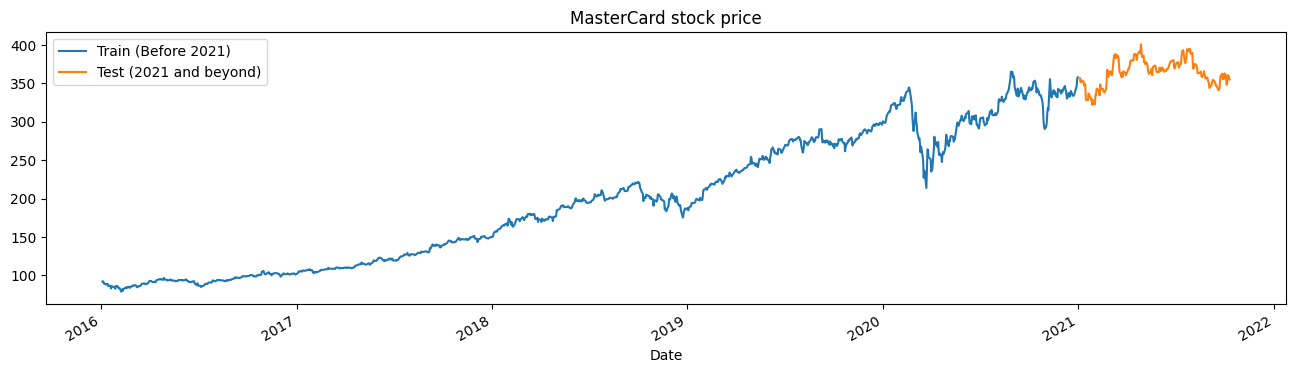

In [5]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()
train_test_plot(dataset,tstart,tend)

In [6]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

In [7]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [8]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [10]:
X_train

array([[[0.04611702],
        [0.04692574],
        [0.04271097],
        ...,
        [0.03565442],
        [0.03815291],
        [0.04196816]],

       [[0.04692574],
        [0.04271097],
        [0.03589075],
        ...,
        [0.03815291],
        [0.04196816],
        [0.04456798]],

       [[0.04271097],
        [0.03589075],
        [0.03545174],
        ...,
        [0.04196816],
        [0.04456798],
        [0.04851835]],

       ...,

       [[0.91439013],
        [0.91661388],
        [0.92741912],
        ...,
        [0.89003545],
        [0.89407059],
        [0.92614221]],

       [[0.91661388],
        [0.92741912],
        [0.92147802],
        ...,
        [0.89407059],
        [0.92614221],
        [0.93713413]],

       [[0.92741912],
        [0.92147802],
        [0.9334469 ],
        ...,
        [0.92614221],
        [0.93713413],
        [0.9686838 ]]])

In [11]:
y_train

array([[0.04456798],
       [0.04851835],
       [0.04848457],
       ...,
       [0.93713413],
       [0.9686838 ],
       [0.97421471]])

In [13]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

***LSTM Model***

In [14]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.summary()

2023-12-07 23:44:42.812511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 23:44:42.858145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 23:44:42.858411: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63626 (248.54 KB)
Trainable params: 63626 (248.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


2023-12-07 23:48:23.365063: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


 1/38 [..............................] - ETA: 41s - loss: 0.2245

2023-12-07 23:48:23.602057: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f900c1204c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-07 23:48:23.602086: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-12-07 23:48:23.607917: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701989303.658468   26751 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 [==============================] - 1s 5ms/step - loss: 0.0152
Epoch 2/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 4/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 5/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 6/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 7/50
38/38 [==============================] - 0s 5ms/step - loss: 9.7534e-04
Epoch 8/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 9/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 10/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 11/50
38/38 [==============================] - 0s 5ms/step - loss: 8.3540e-04
Epoch 12/50
38/38 [==============================] - 0s 5ms/step - loss: 8.4282e-04
Epoch 13/50
38/38 [=============================

In [16]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 [==============================] - 0s 2ms/step


In [17]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

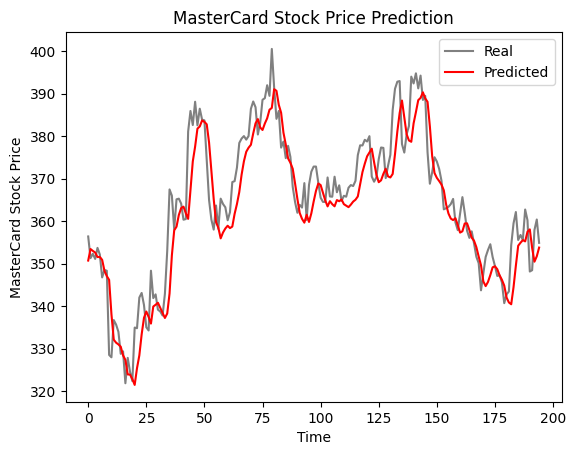

In [18]:
plot_predictions(test_set,predicted_stock_price)

In [19]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 6.91.


***GRU Model***

In [20]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 1s 4ms/step - loss: 0.0088
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 4/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 5/50
38/38 [==============================] - 0s 5ms/step - loss: 8.7059e-04
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 7/50
38/38 [==============================] - 0s 4ms/step - loss: 7.5972e-04
Epoch 8/50
38/38 [==============================] - 0s 5ms/step - loss: 6.8689e-04
Epoch 9/50
38/38 [==============================] - 0s 5ms/step - loss: 6.7987e-04
Epoch 10/50
38/38 [==============================] - 0s 5ms/step - loss: 7.5314e-04
Epoch 11/50
38/38 [==============================] - 0s 5ms/step - loss: 6.3188e-04
Epoch 12/50
38/38 [==============================] - 0s 6ms/step - loss: 5.9362e-04
Epoch 13/50
38/38 [==

7/7 [==============================] - 0s 2ms/step


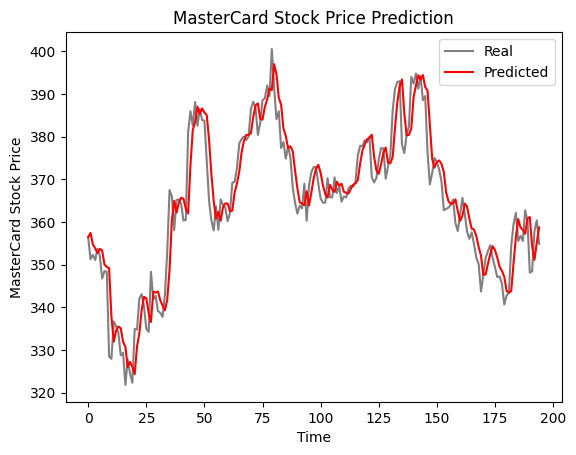

In [24]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [25]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.85.
